<a href="https://colab.research.google.com/github/jonasrauber/foolbox-native-tutorial/blob/master/foolbox-native-tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Activate GPU

1.   Runtime menu
2.   Change runtime type
3.   Hardware accelerator -> GPU

## Get Foolbox

In [1]:
!pip3 install foolbox==3.1.1
# !pip3 install git+https://github.com/bethgelab/foolbox.git

In [2]:
import foolbox as fb

## Get a model

Get a pertrained PyTorch or TensorFlow model, e.g. `torchvision.models.resnet18` or `tf.keras.applications.ResNet50`.

#### PyTorch

In [3]:
import torch
import torchvision

In [4]:
torch.__version__

'2.1.0'

In [5]:
torch.cuda.is_available()

True

In [6]:
model = torchvision.models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model = model.eval()

## Turn your PyTorch / TensorFlow model into a Foolbox model

Don't forget to specify the correct bounds and preprocessing!

#### PyTorch Solution

In [8]:
# PyTorch ResNet18
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)

## Transform bounds

In the following, we want to work with a model that has `(0, 1)` bounds. Use `fmodel.transform_bounds`.

In [9]:
fmodel = fmodel.transform_bounds((0, 1))

In [10]:
assert fmodel.bounds == (0, 1)

## Get some test images

Get a batch of 16 images and the corrresponding labels. You can use `foolbox.utils.samples` to get up to 20 images, but you can also you your own data loader.

In [11]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

## Check the accuracy of your model to make sure you specified the correct preprocessing

In [12]:
fb.utils.accuracy(fmodel, images, labels)

0.9375

In [13]:
type(images), images.shape

(torch.Tensor, torch.Size([16, 3, 224, 224]))

In [14]:
type(labels), labels.shape

(torch.Tensor, torch.Size([16]))

## Run LinfDeepFool

In [15]:
attack = fb.attacks.LinfDeepFoolAttack()

In [16]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

In [17]:
is_adv

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')

## Use EagerPy tensors and rerun the attack

In [18]:
import eagerpy as ep

In [19]:
images = ep.astensor(images)
labels = ep.astensor(labels)

In [20]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

In [21]:
is_adv

PyTorchTensor(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
                      True, True, True, True], device='cuda:0'))

In [22]:
is_adv.float32().mean().item()

1.0

## Using the Misclassification criterion explicitly

In [23]:
criterion = fb.criteria.Misclassification(labels)

In [24]:
raw, clipped, is_adv = attack(fmodel, images, criterion, epsilons=0.03)

In [25]:
is_adv

PyTorchTensor(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
                      True, True, True, True], device='cuda:0'))

## Run the attack using many epsilons

In [26]:
import numpy as np

In [27]:
epsilons = np.linspace(0.0, 0.005, num=20)

In [28]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

In [29]:
is_adv.shape

torch.Size([20, 16])

In [30]:
is_adv.float32().mean(axis=-1)

PyTorchTensor(tensor([0.0625, 0.1875, 0.3125, 0.5625, 0.6875, 0.8125, 0.8750, 0.9375, 0.9375,
                      0.9375, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
                      1.0000, 1.0000], device='cuda:0'))

In [31]:
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)

In [32]:
robust_accuracy

PyTorchTensor(tensor([0.9375, 0.8125, 0.6875, 0.4375, 0.3125, 0.1875, 0.1250, 0.0625, 0.0625,
                      0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                      0.0000, 0.0000], device='cuda:0'))

## Plot the robust accuracy as a function of epsilon

In [33]:
import matplotlib.pyplot as plt

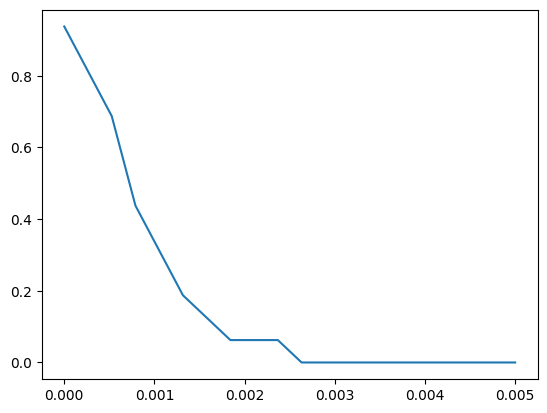

In [34]:
plt.plot(epsilons, robust_accuracy.numpy())

We can see that **the model is not robust** at all. Even extremely small perturbations (Linf norm of 0.003 for pixels between 0 and 1) are sufficient
to change the classification.

## Run a targeted attack

In [35]:
labels

PyTorchTensor(tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
                      129,  99], device='cuda:0'))

In [36]:
target_classes = (labels + 200) % 1000

In [37]:
target_classes

PyTorchTensor(tensor([443, 759, 638, 190, 149,  53, 809, 809, 115, 655, 741, 830, 941, 671,
                      329, 299], device='cuda:0'))

In [38]:
criterion = fb.criteria.TargetedMisclassification(target_classes)

In [39]:
attack = fb.attacks.L2CarliniWagnerAttack(steps=100)
# Note: 100 is too little -> results will be bad = perturbations will be relatively large (but 1000 takes much longer)

In [40]:
# epsilons = np.linspace(0.0, 10.0, num=20)
epsilons = None

In [41]:
advs, _, is_adv = attack(fmodel, images, criterion, epsilons=epsilons)

In [42]:
is_adv

PyTorchTensor(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
                      True, True, True, True], device='cuda:0'))

In [43]:
fb.distances.l2(images, advs)

PyTorchTensor(tensor([0.8953, 0.9556, 0.5445, 0.8376, 0.7493, 1.3749, 0.5203, 0.7797, 0.8883,
                      1.0080, 0.7852, 0.4247, 1.7345, 0.3253, 0.6964, 0.7336],
                     device='cuda:0'))

In [44]:
# attack_success_rate = is_adv.float32().mean(axis=-1)

In [45]:
# plt.plot(epsilons, attack_success_rate.numpy())

## Visualizing adversarial examples and perturbations

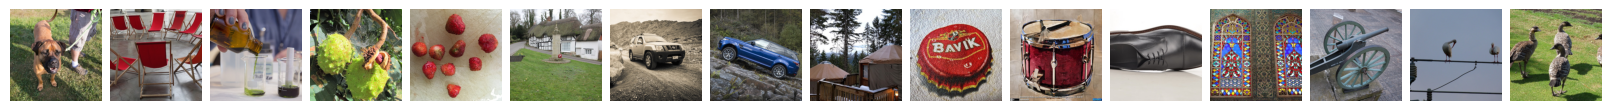

In [46]:
fb.plot.images(images)

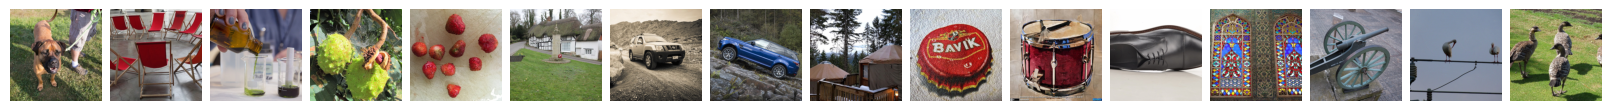

In [47]:
fb.plot.images(advs)

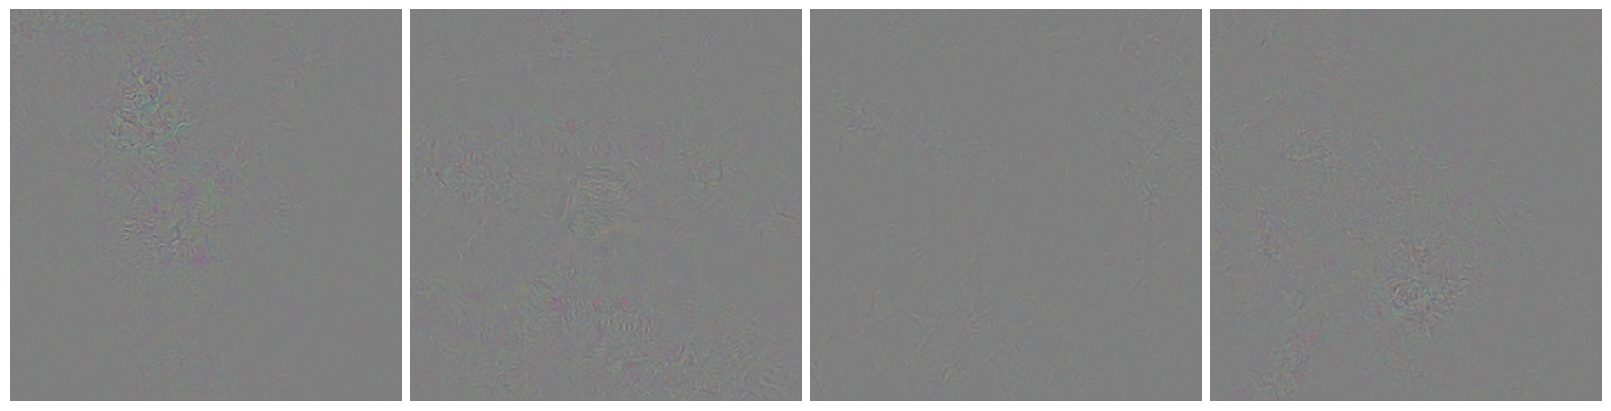

In [48]:
fb.plot.images(advs - images, n=4, bounds=(-0.1, 0.1), scale=4.)

The adversarial examples look like the orignal (clean) images. That shows that **the model is not robust against adversarial attacks**. Tiny perturbations mislead the model and allow the attacker to control which class is recognized.

## Continuing from here ...



*   Repeating an attack (`attack = attack.repeat(3)`)
*   Getting the per-sample worst-case over multiple attacks
    * stack attack results and take max over the attacks before taking the mean over samples
*   Gradient estimators (`fb.gradient_estimators.*`)
*   Transfer attacks using gradient substitution (see examples)

